In [1]:
import torch
import math
import numpy as np
from torch import nn
from typing import List, Tuple
from tqdm import tqdm
import matplotlib.pyplot as plt
from utils import Logger
from torchvision import transforms, datasets

In [2]:
class Data:

    def __init__(self):
        compose = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((.5,), (.5,))
        ])
        data = datasets.MNIST(root='./dataset', train=True, transform=compose, download=True)
        self.loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)


In [3]:
class Discriminator(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(Discriminator, self).__init__()
        n_features = 784
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

class Generator(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(Generator, self).__init__()
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x


In [4]:
class Experiment:

    num_test_samples = 16

    def __init__(self):
        self.data_loader = Data().loader
        self.num_batches = len(self.data_loader)
        self.generator = Generator()
        self.discriminator = Discriminator()
        self.d_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=0.0002)
        self.g_optimizer = torch.optim.Adam(self.generator.parameters(), lr=0.0002)
        self.criterion = nn.BCELoss()
        self.logger = Logger(model_name='VGAN', data_name='MNIST')
    
    def noise(self, size):
        return torch.randn(size, 100)
    
    def ones_target(self, size):
        return torch.ones(size, 1)

    def zeros_target(self, size):
        return torch.zeros(size, 1)
    
    def train_discriminator(self, optimizer, real_data, fake_data):
        N = real_data.size(0)
        # Reset gradients
        optimizer.zero_grad()
        
        # 1.1 Train on Real Data
        prediction_real = self.discriminator(real_data)
        # Calculate error and backpropagate
        error_real = self.criterion(prediction_real, self.ones_target(N) )
        error_real.backward()

        # 1.2 Train on Fake Data
        prediction_fake = self.discriminator(fake_data)
        # Calculate error and backpropagate
        error_fake = self.criterion(prediction_fake, self.zeros_target(N))
        error_fake.backward()
        
        # 1.3 Update weights with gradients
        optimizer.step()
        
        # Return error and predictions for real and fake inputs
        return error_real + error_fake, prediction_real, prediction_fake
    
    def train_generator(self, optimizer, fake_data):
        N = fake_data.size(0)
        # Reset gradients
        optimizer.zero_grad()
        # Sample noise and generate fake data
        prediction = self.discriminator(fake_data)
        # Calculate error and backpropagate
        error = self.criterion(prediction, self.ones_target(N))
        error.backward()
        # Update weights with gradients
        optimizer.step()
        # Return error
        return error
    
    def vectors_to_images(self, vectors):
        return vectors.view(vectors.size(0), 1, 28, 28)
    
    def images_to_vectors(self, images):
        return images.view(images.size(0), 784)
    
    def run(self, epochs):
        for epoch in tqdm(range(epochs), "Training"):
            for n_batch, (real_batch,_) in enumerate(self.data_loader):
                N = real_batch.size(0)
                # 1. Train Discriminator
                real_data = self.images_to_vectors(real_batch)
                # Generate fake data and detach 
                # (so gradients are not calculated for generator)
                fake_data = self.generator(self.noise(N)).detach()
                # Train D
                d_error, d_pred_real, d_pred_fake = self.train_discriminator(self.d_optimizer, real_data, fake_data)

                # 2. Train Generator
                # Generate fake data
                fake_data = self.generator(self.noise(N))
                # Train G
                g_error = self.train_generator(self.g_optimizer, fake_data)
                # Log batch error
                self.logger.log(d_error, g_error, epoch, n_batch, self.num_batches)
                # Display Progress every few batches
                if (n_batch) % 100 == 0: 
                    test_images = self.vectors_to_images(self.generator(self.noise(self.num_test_samples)))
                    test_images = test_images.data
                    self.logger.log_images(
                        test_images, self.num_test_samples, 
                        epoch, n_batch, self.num_batches
                    )
                    # Display status Logs
                    self.logger.display_status(
                        epoch, epochs, n_batch, self.num_batches,
                        d_error, g_error, d_pred_real, d_pred_fake
                    )

Training:   0%|          | 0/200 [00:00<?, ?it/s]

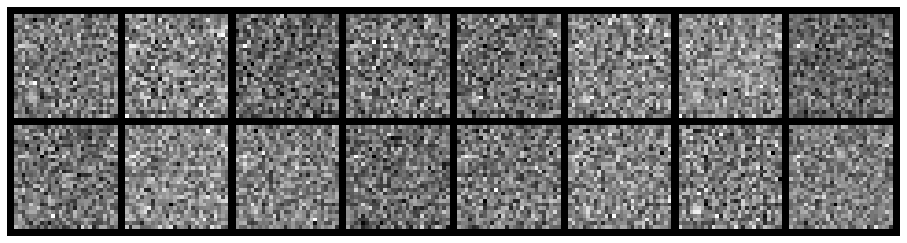

Epoch: [0/200], Batch Num: [0/600]
Discriminator Loss: 1.3884, Generator Loss: 0.6779
D(x): 0.5070, D(G(z)): 0.5077


Epoch: [0/200], Batch Num: [100/600]
Discriminator Loss: 1.8337, Generator Loss: 0.5344
D(x): 0.9322, D(G(z)): 0.8175


Epoch: [0/200], Batch Num: [200/600]
Discriminator Loss: 0.9671, Generator Loss: 1.7212
D(x): 0.6624, D(G(z)): 0.3812


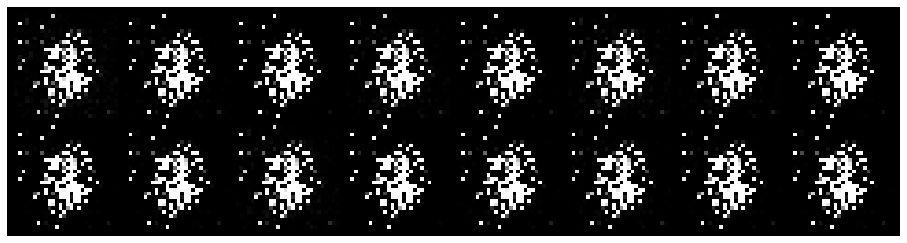

Epoch: [0/200], Batch Num: [300/600]
Discriminator Loss: 0.0144, Generator Loss: 7.9111
D(x): 0.9916, D(G(z)): 0.0056


Epoch: [0/200], Batch Num: [400/600]
Discriminator Loss: 0.0259, Generator Loss: 5.9094
D(x): 0.9965, D(G(z)): 0.0217


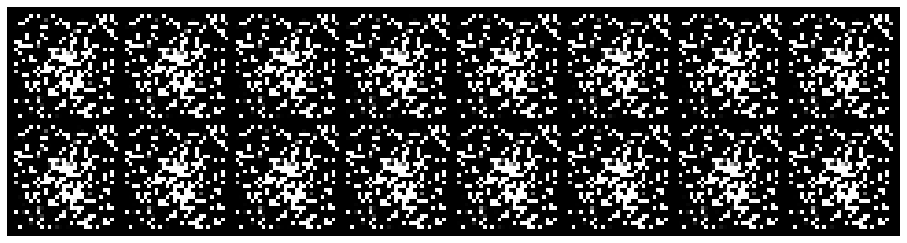

Epoch: [0/200], Batch Num: [500/600]
Discriminator Loss: 0.0134, Generator Loss: 9.6079
D(x): 0.9886, D(G(z)): 0.0012
Training:   0%|          | 1/200 [00:35<1:56:14, 35.05s/it]

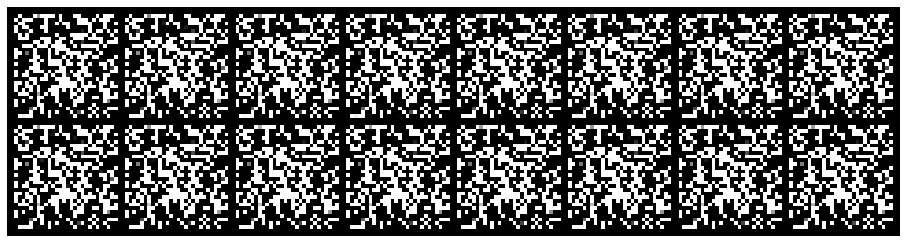

Epoch: [1/200], Batch Num: [0/600]
Discriminator Loss: 0.0044, Generator Loss: 8.9167
D(x): 0.9987, D(G(z)): 0.0031


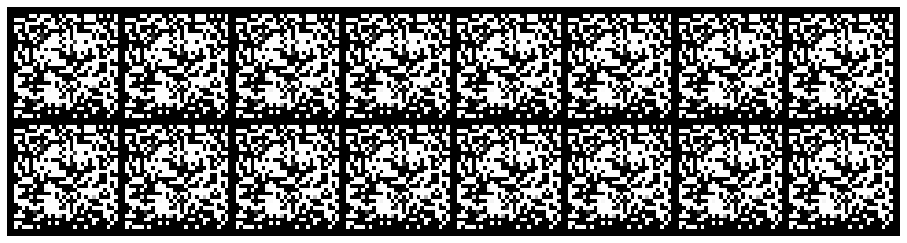

Epoch: [1/200], Batch Num: [100/600]
Discriminator Loss: 0.0011, Generator Loss: 8.4067
D(x): 0.9996, D(G(z)): 0.0007


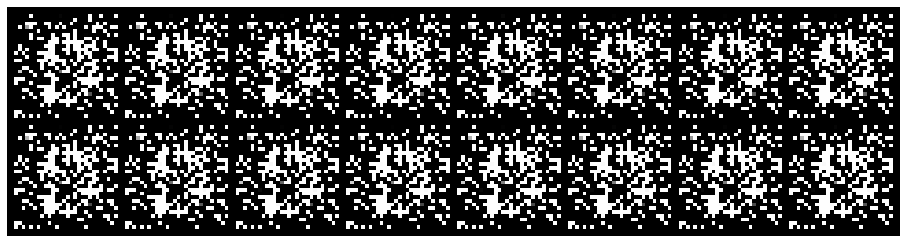

Epoch: [1/200], Batch Num: [200/600]
Discriminator Loss: 0.0009, Generator Loss: 9.6039
D(x): 0.9995, D(G(z)): 0.0004


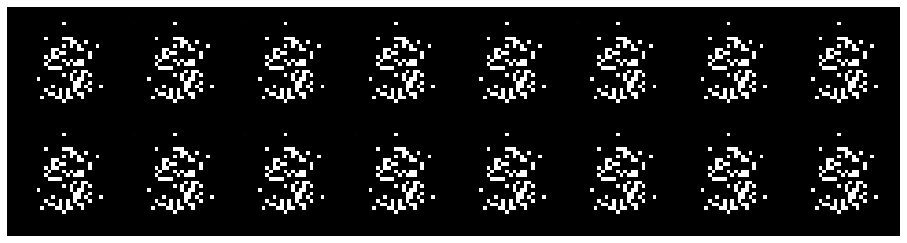

Epoch: [1/200], Batch Num: [300/600]
Discriminator Loss: 0.0047, Generator Loss: 10.0035
D(x): 0.9989, D(G(z)): 0.0034


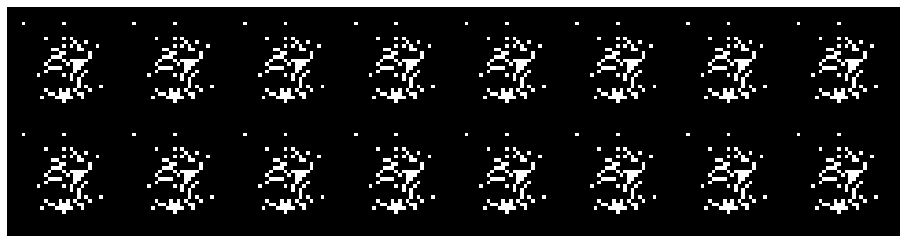

Epoch: [1/200], Batch Num: [400/600]
Discriminator Loss: 0.0005, Generator Loss: 13.3419
D(x): 0.9995, D(G(z)): 0.0000


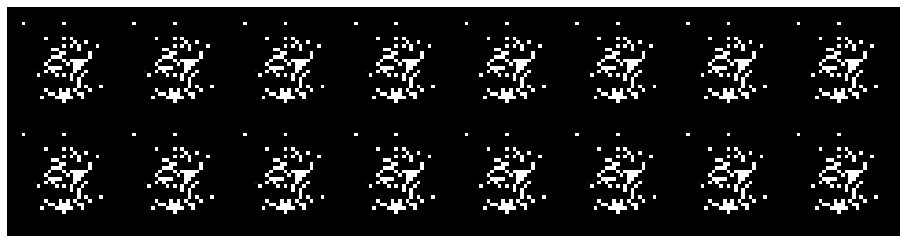

Epoch: [1/200], Batch Num: [500/600]
Discriminator Loss: 0.0003, Generator Loss: 13.6423
D(x): 0.9997, D(G(z)): 0.0000
Training:   1%|          | 2/200 [01:10<1:55:50, 35.10s/it]

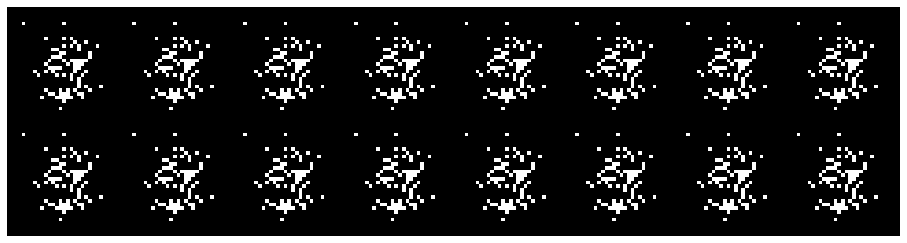

Epoch: [2/200], Batch Num: [0/600]
Discriminator Loss: 0.0002, Generator Loss: 13.2526
D(x): 0.9999, D(G(z)): 0.0000


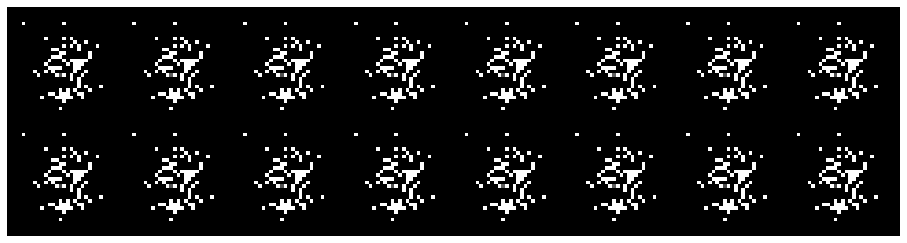

Epoch: [2/200], Batch Num: [100/600]
Discriminator Loss: 0.0001, Generator Loss: 13.9885
D(x): 0.9999, D(G(z)): 0.0000


Epoch: [2/200], Batch Num: [200/600]
Discriminator Loss: 0.0001, Generator Loss: 14.4019
D(x): 0.9999, D(G(z)): 0.0000


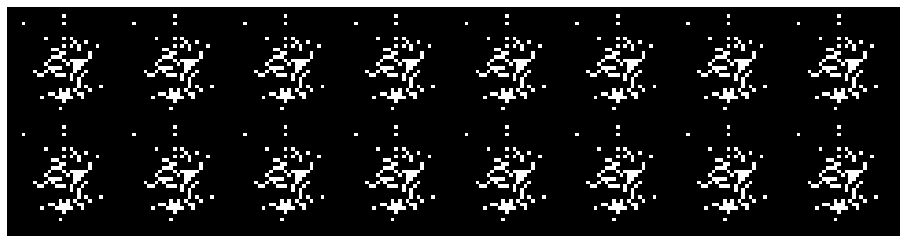

Epoch: [2/200], Batch Num: [300/600]
Discriminator Loss: 0.0003, Generator Loss: 18.9503
D(x): 0.9998, D(G(z)): 0.0000


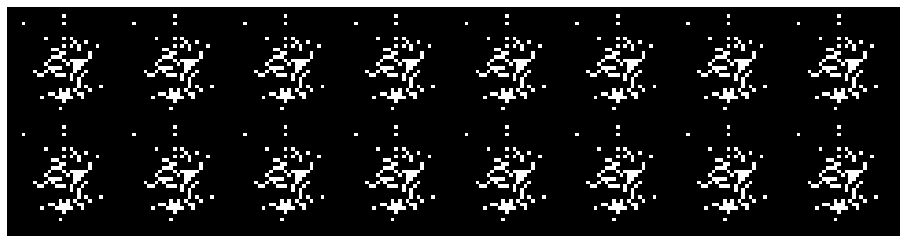

Epoch: [2/200], Batch Num: [400/600]
Discriminator Loss: 0.0001, Generator Loss: 15.5936
D(x): 1.0000, D(G(z)): 0.0000


Epoch: [2/200], Batch Num: [500/600]
Discriminator Loss: 0.0000, Generator Loss: 15.5513
D(x): 1.0000, D(G(z)): 0.0000
Training:   2%|▏         | 3/200 [01:47<1:56:52, 35.60s/it]

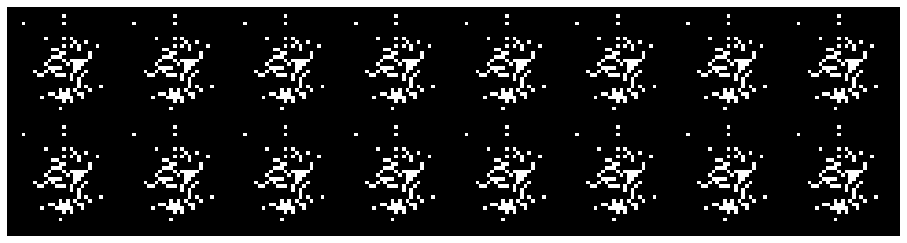

Epoch: [3/200], Batch Num: [0/600]
Discriminator Loss: 0.0000, Generator Loss: 16.3141
D(x): 1.0000, D(G(z)): 0.0000


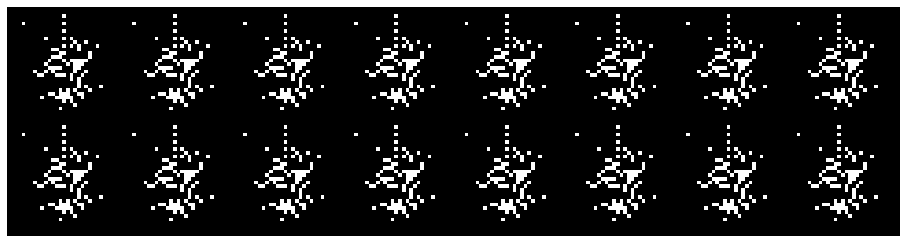

Epoch: [3/200], Batch Num: [100/600]
Discriminator Loss: 0.0000, Generator Loss: 15.6149
D(x): 1.0000, D(G(z)): 0.0000


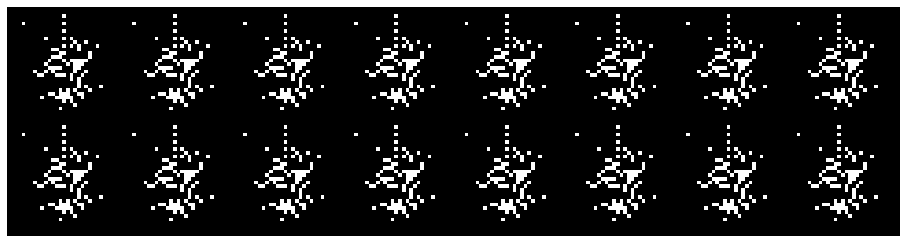

Epoch: [3/200], Batch Num: [200/600]
Discriminator Loss: 0.0001, Generator Loss: 16.0969
D(x): 0.9999, D(G(z)): 0.0000


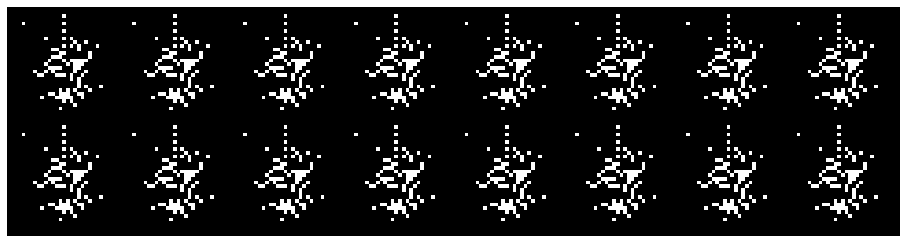

Epoch: [3/200], Batch Num: [300/600]
Discriminator Loss: 0.0000, Generator Loss: 16.4370
D(x): 1.0000, D(G(z)): 0.0000


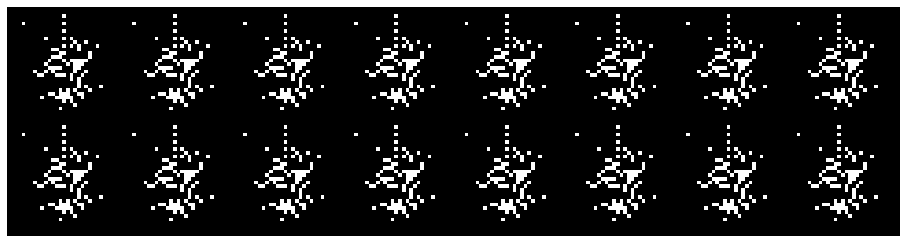

Epoch: [3/200], Batch Num: [400/600]
Discriminator Loss: 0.0001, Generator Loss: 17.0624
D(x): 0.9999, D(G(z)): 0.0000


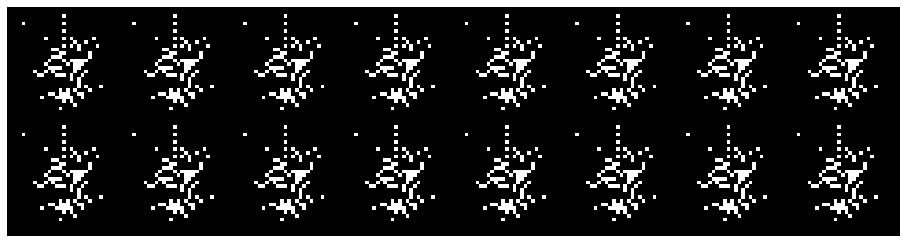

Epoch: [3/200], Batch Num: [500/600]
Discriminator Loss: 0.0000, Generator Loss: 15.9801
D(x): 1.0000, D(G(z)): 0.0000
Training:   2%|▏         | 4/200 [02:22<1:56:37, 35.70s/it]

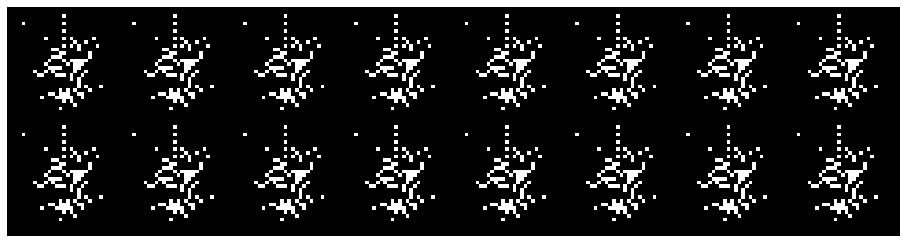

Epoch: [4/200], Batch Num: [0/600]
Discriminator Loss: 0.0000, Generator Loss: 16.5021
D(x): 1.0000, D(G(z)): 0.0000


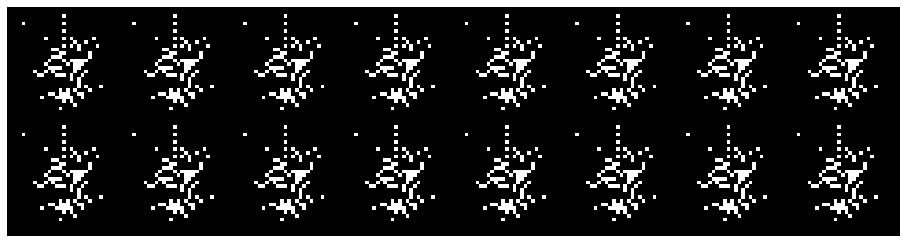

Epoch: [4/200], Batch Num: [100/600]
Discriminator Loss: 0.0000, Generator Loss: 16.6064
D(x): 1.0000, D(G(z)): 0.0000


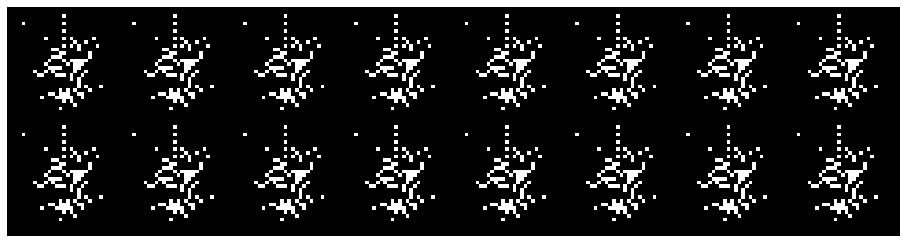

Epoch: [4/200], Batch Num: [200/600]
Discriminator Loss: 0.0000, Generator Loss: 17.9704
D(x): 1.0000, D(G(z)): 0.0000


Epoch: [4/200], Batch Num: [300/600]
Discriminator Loss: 0.0000, Generator Loss: 17.4461
D(x): 1.0000, D(G(z)): 0.0000


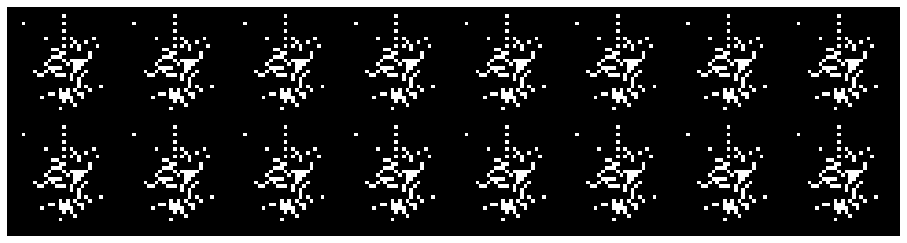

Epoch: [4/200], Batch Num: [400/600]
Discriminator Loss: 0.0000, Generator Loss: 17.8826
D(x): 1.0000, D(G(z)): 0.0000


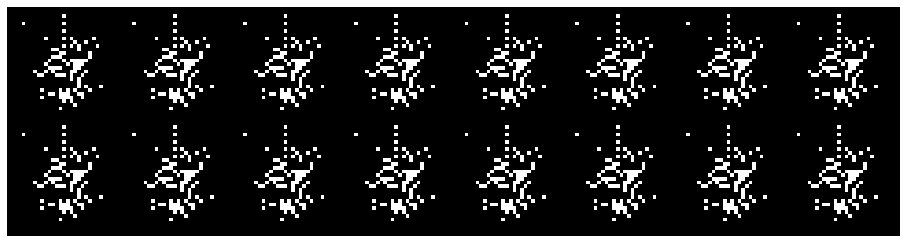

Epoch: [4/200], Batch Num: [500/600]
Discriminator Loss: 0.0000, Generator Loss: 16.7689
D(x): 1.0000, D(G(z)): 0.0000
Training:   2%|▎         | 5/200 [02:59<1:56:37, 35.88s/it]

Epoch: [5/200], Batch Num: [0/600]
Discriminator Loss: 0.0000, Generator Loss: 18.0049
D(x): 1.0000, D(G(z)): 0.0000


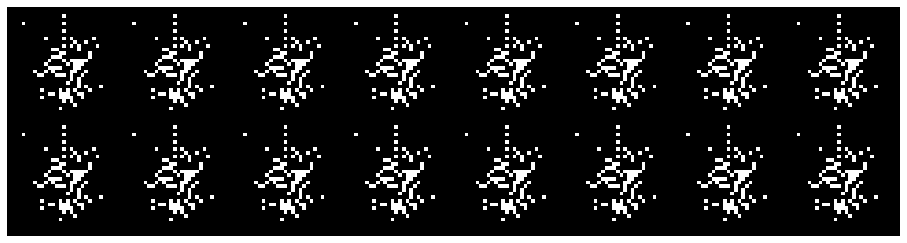

Epoch: [5/200], Batch Num: [100/600]
Discriminator Loss: 0.0000, Generator Loss: 18.2718
D(x): 1.0000, D(G(z)): 0.0000


Epoch: [5/200], Batch Num: [200/600]
Discriminator Loss: 0.0000, Generator Loss: 17.0177
D(x): 1.0000, D(G(z)): 0.0000


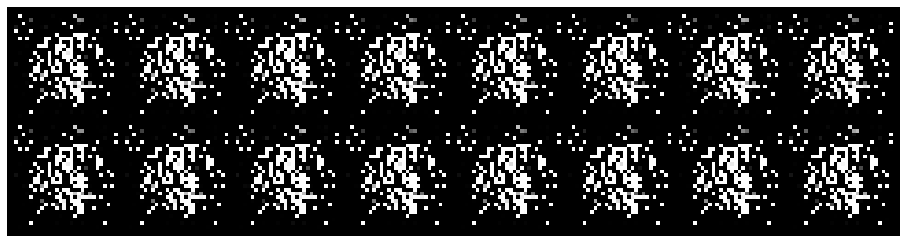

Epoch: [5/200], Batch Num: [300/600]
Discriminator Loss: 0.0007, Generator Loss: 13.2370
D(x): 0.9998, D(G(z)): 0.0004


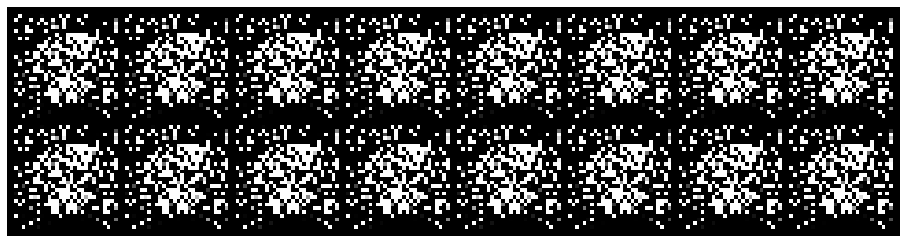

Epoch: [5/200], Batch Num: [400/600]
Discriminator Loss: 0.0000, Generator Loss: 56.4072
D(x): 1.0000, D(G(z)): 0.0000


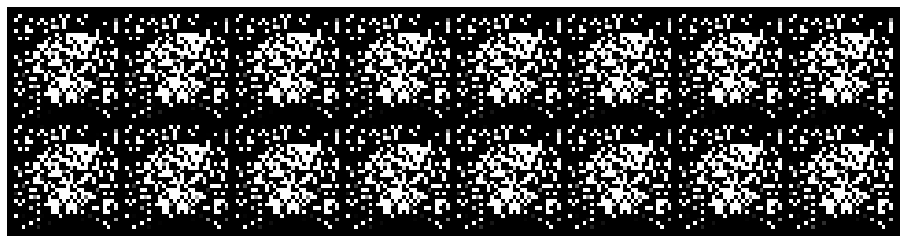

Epoch: [5/200], Batch Num: [500/600]
Discriminator Loss: 0.0000, Generator Loss: 58.4501
D(x): 1.0000, D(G(z)): 0.0000
Training:   3%|▎         | 6/200 [03:48<2:09:04, 39.92s/it]

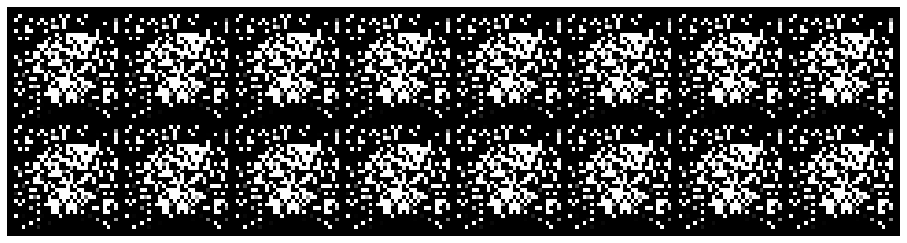

Epoch: [6/200], Batch Num: [0/600]
Discriminator Loss: 0.0000, Generator Loss: 60.3065
D(x): 1.0000, D(G(z)): 0.0000


Epoch: [6/200], Batch Num: [100/600]
Discriminator Loss: 0.0000, Generator Loss: 59.6421
D(x): 1.0000, D(G(z)): 0.0000


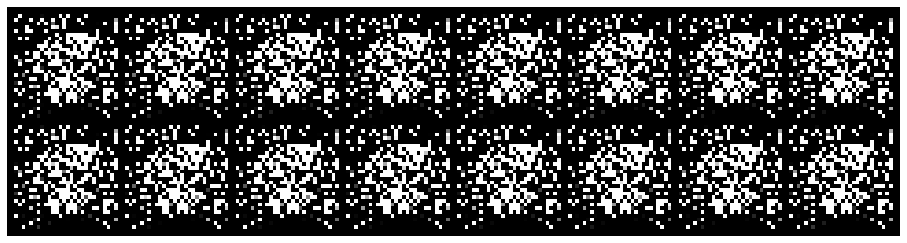

Epoch: [6/200], Batch Num: [200/600]
Discriminator Loss: 0.0000, Generator Loss: 58.9995
D(x): 1.0000, D(G(z)): 0.0000


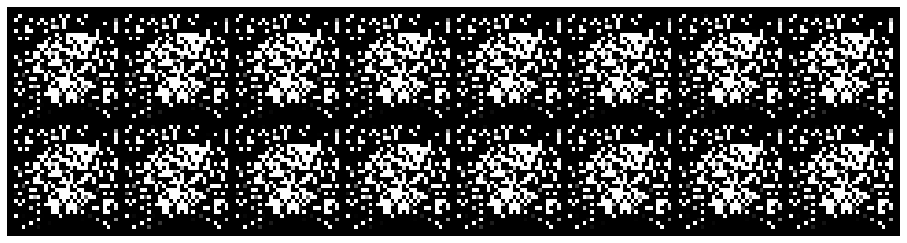

Epoch: [6/200], Batch Num: [300/600]
Discriminator Loss: 0.0000, Generator Loss: 58.4896
D(x): 1.0000, D(G(z)): 0.0000


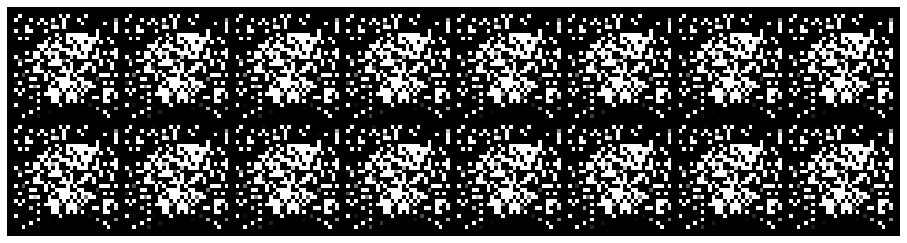

Epoch: [6/200], Batch Num: [400/600]
Discriminator Loss: 0.0000, Generator Loss: 57.5873
D(x): 1.0000, D(G(z)): 0.0000


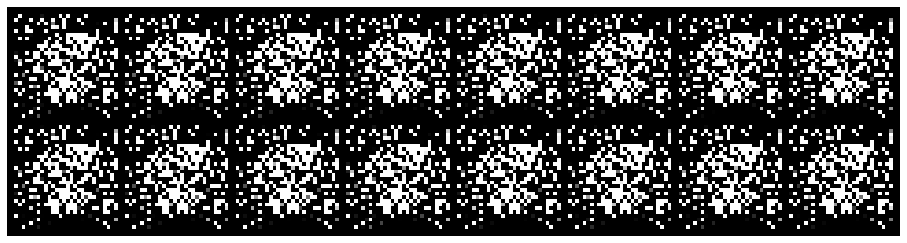

Epoch: [6/200], Batch Num: [500/600]
Discriminator Loss: 0.0000, Generator Loss: 58.8771
D(x): 1.0000, D(G(z)): 0.0000
Training:   4%|▎         | 7/200 [05:01<2:39:50, 49.69s/it]

Epoch: [7/200], Batch Num: [0/600]
Discriminator Loss: 0.0000, Generator Loss: 59.4725
D(x): 1.0000, D(G(z)): 0.0000


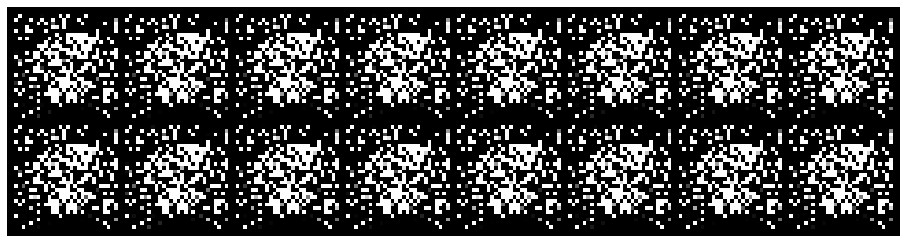

Epoch: [7/200], Batch Num: [100/600]
Discriminator Loss: 0.0000, Generator Loss: 58.8718
D(x): 1.0000, D(G(z)): 0.0000


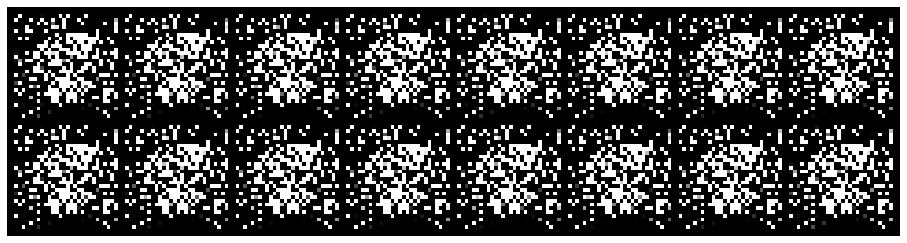

Epoch: [7/200], Batch Num: [200/600]
Discriminator Loss: 0.0000, Generator Loss: 57.6208
D(x): 1.0000, D(G(z)): 0.0000


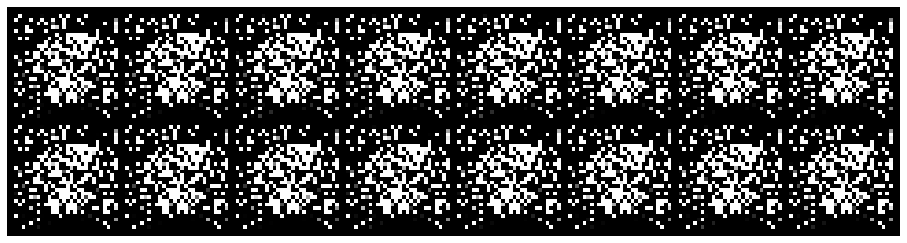

Epoch: [7/200], Batch Num: [300/600]
Discriminator Loss: 0.0000, Generator Loss: 59.5746
D(x): 1.0000, D(G(z)): 0.0000


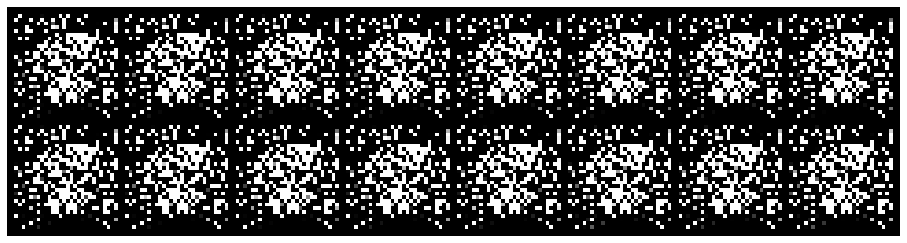

Epoch: [7/200], Batch Num: [400/600]
Discriminator Loss: 0.0000, Generator Loss: 57.8147
D(x): 1.0000, D(G(z)): 0.0000


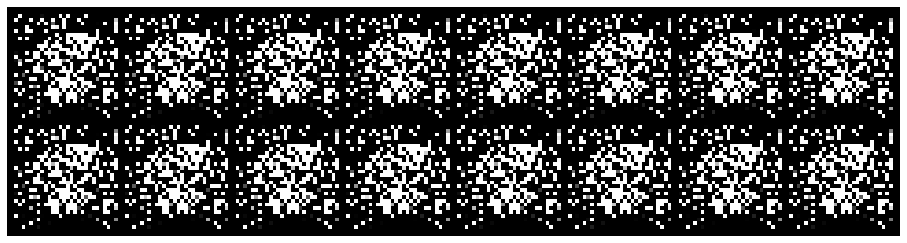

Epoch: [7/200], Batch Num: [500/600]
Discriminator Loss: 0.0000, Generator Loss: 58.7969
D(x): 1.0000, D(G(z)): 0.0000
Training:   4%|▍         | 8/200 [06:12<3:00:06, 56.28s/it]

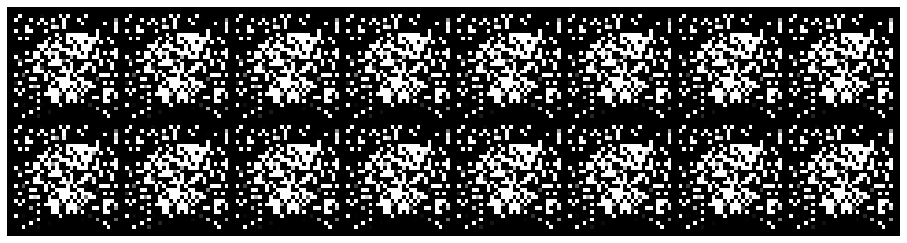

Epoch: [8/200], Batch Num: [0/600]
Discriminator Loss: 0.0000, Generator Loss: 56.3747
D(x): 1.0000, D(G(z)): 0.0000


Epoch: [8/200], Batch Num: [100/600]
Discriminator Loss: 0.0000, Generator Loss: 58.7296
D(x): 1.0000, D(G(z)): 0.0000


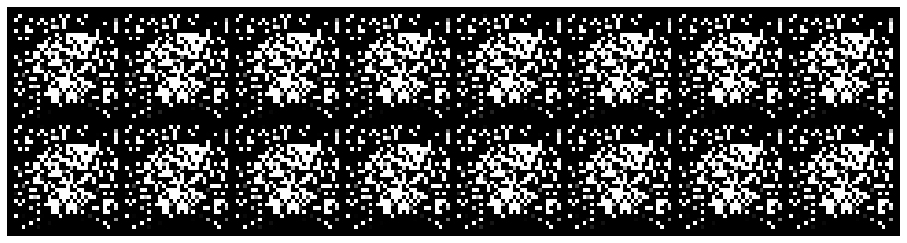

Epoch: [8/200], Batch Num: [200/600]
Discriminator Loss: 0.0000, Generator Loss: 57.7432
D(x): 1.0000, D(G(z)): 0.0000


Epoch: [8/200], Batch Num: [300/600]
Discriminator Loss: 0.0000, Generator Loss: 58.4446
D(x): 1.0000, D(G(z)): 0.0000


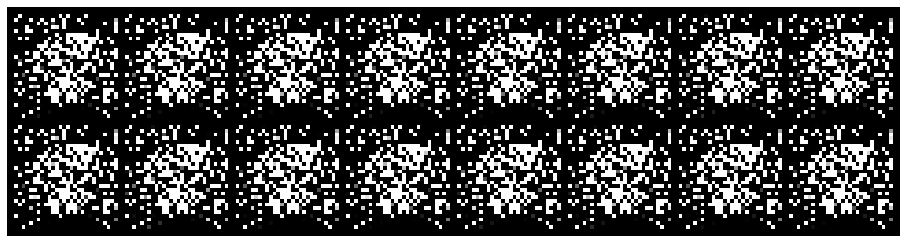

Epoch: [8/200], Batch Num: [400/600]
Discriminator Loss: 0.0000, Generator Loss: 58.2273
D(x): 1.0000, D(G(z)): 0.0000


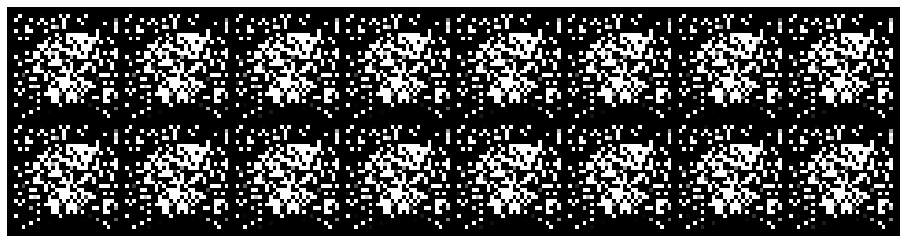

Epoch: [8/200], Batch Num: [500/600]
Discriminator Loss: 0.0000, Generator Loss: 57.3737
D(x): 1.0000, D(G(z)): 0.0000
Training:   4%|▍         | 9/200 [07:21<3:10:53, 59.97s/it]

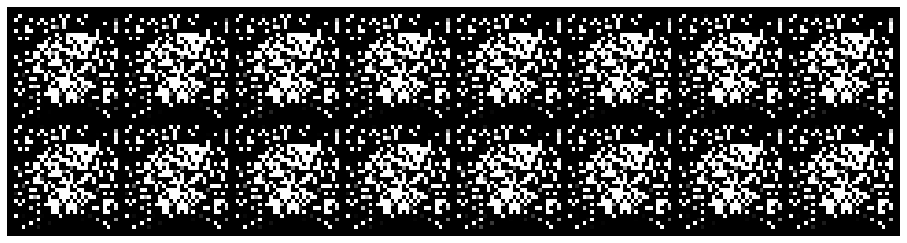

Epoch: [9/200], Batch Num: [0/600]
Discriminator Loss: 0.0000, Generator Loss: 57.5564
D(x): 1.0000, D(G(z)): 0.0000


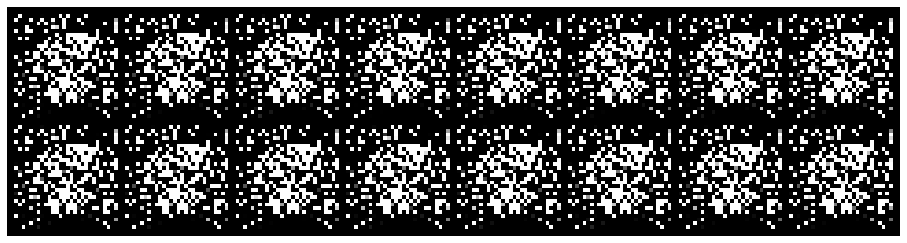

Epoch: [9/200], Batch Num: [100/600]
Discriminator Loss: 0.0000, Generator Loss: 58.0089
D(x): 1.0000, D(G(z)): 0.0000


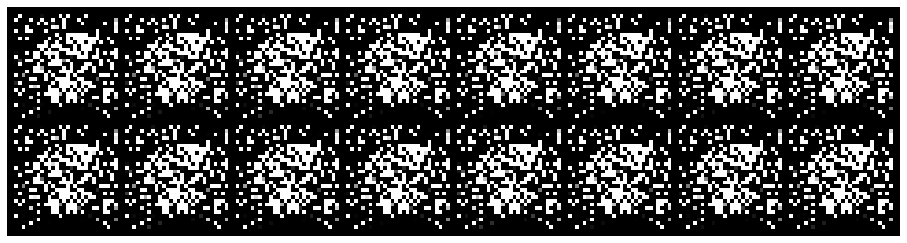

Epoch: [9/200], Batch Num: [200/600]
Discriminator Loss: 0.0000, Generator Loss: 56.6911
D(x): 1.0000, D(G(z)): 0.0000


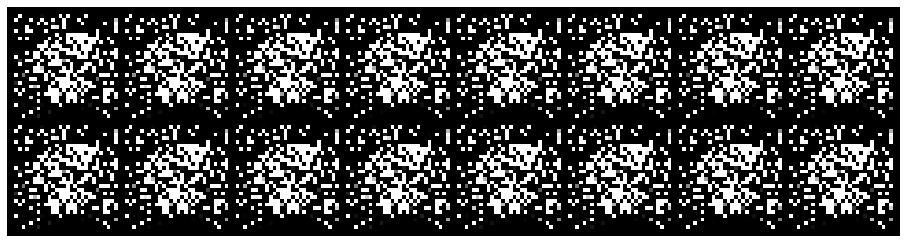

Epoch: [9/200], Batch Num: [300/600]
Discriminator Loss: 0.0000, Generator Loss: 56.0911
D(x): 1.0000, D(G(z)): 0.0000


Epoch: [9/200], Batch Num: [400/600]
Discriminator Loss: 0.0000, Generator Loss: 54.8544
D(x): 1.0000, D(G(z)): 0.0000


Epoch: [9/200], Batch Num: [500/600]
Discriminator Loss: 0.0000, Generator Loss: 54.6714
D(x): 1.0000, D(G(z)): 0.0000
Training:   5%|▌         | 10/200 [08:29<3:17:58, 62.52s/it]

Epoch: [10/200], Batch Num: [0/600]
Discriminator Loss: 0.0000, Generator Loss: 55.1087
D(x): 1.0000, D(G(z)): 0.0000


Epoch: [10/200], Batch Num: [100/600]
Discriminator Loss: 0.0000, Generator Loss: 53.8740
D(x): 1.0000, D(G(z)): 0.0000


Epoch: [10/200], Batch Num: [200/600]
Discriminator Loss: 0.0000, Generator Loss: 52.2097
D(x): 1.0000, D(G(z)): 0.0000


Epoch: [10/200], Batch Num: [300/600]
Discriminator Loss: 0.0000, Generator Loss: 48.5373
D(x): 1.0000, D(G(z)): 0.0000


Epoch: [10/200], Batch Num: [400/600]
Discriminator Loss: 0.0000, Generator Loss: 39.9629
D(x): 1.0000, D(G(z)): 0.0000


Epoch: [10/200], Batch Num: [500/600]
Discriminator Loss: 0.0000, Generator Loss: 28.3224
D(x): 1.0000, D(G(z)): 0.0000
Training:   6%|▌         | 11/200 [09:19<3:04:49, 58.68s/it]

Epoch: [11/200], Batch Num: [0/600]
Discriminator Loss: 0.0000, Generator Loss: 85.2515
D(x): 1.0000, D(G(z)): 0.0000


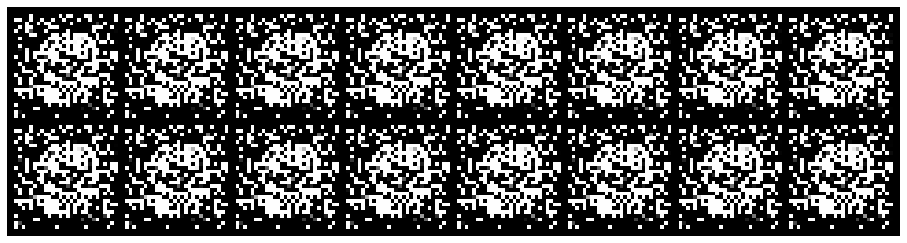

Epoch: [11/200], Batch Num: [100/600]
Discriminator Loss: 0.0000, Generator Loss: 85.8877
D(x): 1.0000, D(G(z)): 0.0000


Epoch: [11/200], Batch Num: [200/600]
Discriminator Loss: 0.0000, Generator Loss: 84.0756
D(x): 1.0000, D(G(z)): 0.0000


Epoch: [11/200], Batch Num: [300/600]
Discriminator Loss: 0.0000, Generator Loss: 85.3698
D(x): 1.0000, D(G(z)): 0.0000


Epoch: [11/200], Batch Num: [400/600]
Discriminator Loss: 0.0000, Generator Loss: 86.3990
D(x): 1.0000, D(G(z)): 0.0000


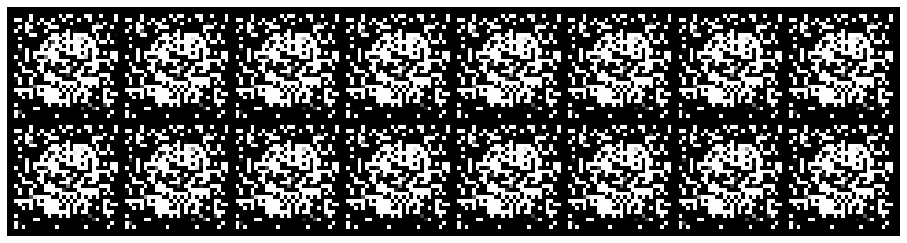

Epoch: [11/200], Batch Num: [500/600]
Discriminator Loss: 0.0000, Generator Loss: 85.4948
D(x): 1.0000, D(G(z)): 0.0000
Training:   6%|▌         | 12/200 [09:52<2:40:08, 51.11s/it]

Epoch: [12/200], Batch Num: [0/600]
Discriminator Loss: 0.0000, Generator Loss: 85.4139
D(x): 1.0000, D(G(z)): 0.0000


Epoch: [12/200], Batch Num: [100/600]
Discriminator Loss: 0.0000, Generator Loss: 87.2176
D(x): 1.0000, D(G(z)): 0.0000


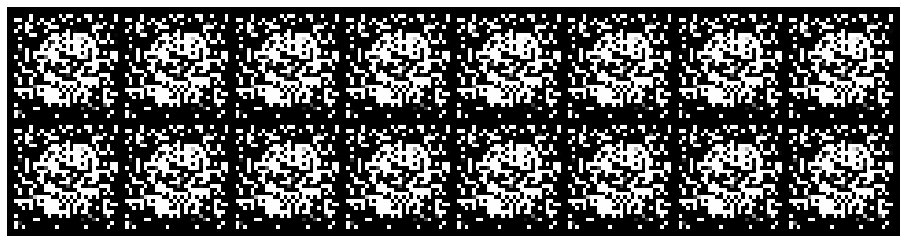

Epoch: [12/200], Batch Num: [200/600]
Discriminator Loss: 0.0000, Generator Loss: 83.4467
D(x): 1.0000, D(G(z)): 0.0000


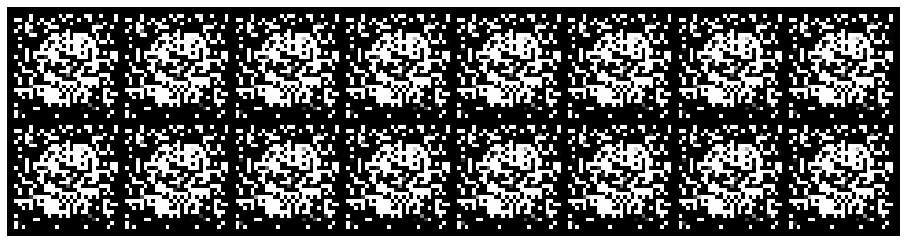

Epoch: [12/200], Batch Num: [300/600]
Discriminator Loss: 0.0000, Generator Loss: 85.6065
D(x): 1.0000, D(G(z)): 0.0000


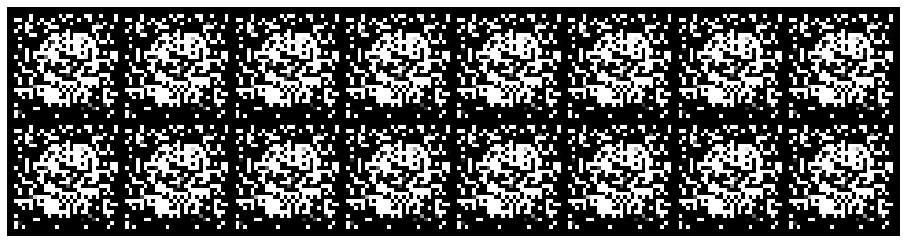

Epoch: [12/200], Batch Num: [400/600]
Discriminator Loss: 0.0000, Generator Loss: 83.8933
D(x): 1.0000, D(G(z)): 0.0000


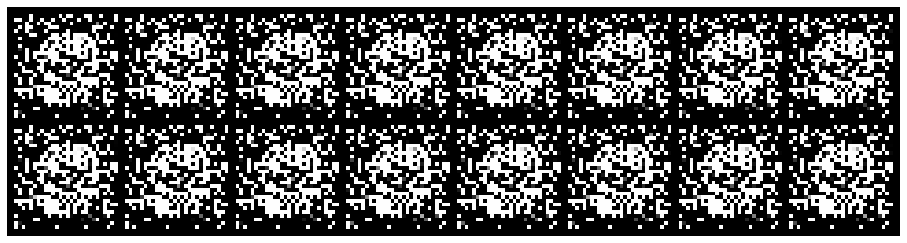

Epoch: [12/200], Batch Num: [500/600]
Discriminator Loss: 0.0000, Generator Loss: 83.9962
D(x): 1.0000, D(G(z)): 0.0000
Training:   6%|▋         | 13/200 [10:26<2:22:54, 45.85s/it]

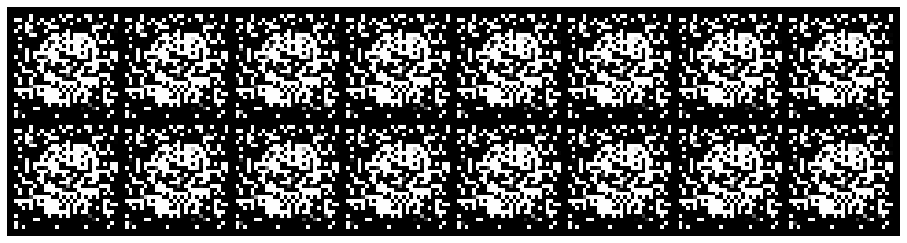

Epoch: [13/200], Batch Num: [0/600]
Discriminator Loss: 0.0000, Generator Loss: 84.5175
D(x): 1.0000, D(G(z)): 0.0000


Epoch: [13/200], Batch Num: [100/600]
Discriminator Loss: 0.0000, Generator Loss: 85.4941
D(x): 1.0000, D(G(z)): 0.0000


Epoch: [13/200], Batch Num: [200/600]
Discriminator Loss: 0.0000, Generator Loss: 86.3084
D(x): 1.0000, D(G(z)): 0.0000


Epoch: [13/200], Batch Num: [300/600]
Discriminator Loss: 0.0000, Generator Loss: 84.3263
D(x): 1.0000, D(G(z)): 0.0000


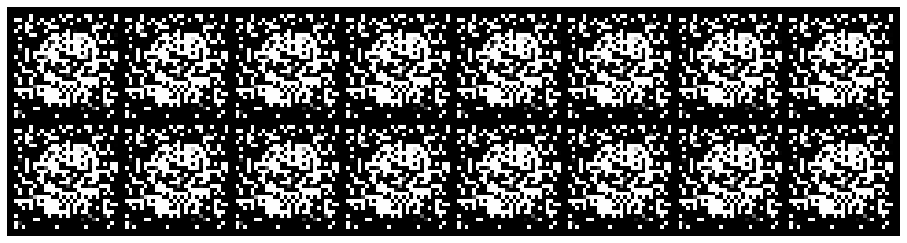

Epoch: [13/200], Batch Num: [400/600]
Discriminator Loss: 0.0000, Generator Loss: 85.4038
D(x): 1.0000, D(G(z)): 0.0000


Epoch: [13/200], Batch Num: [500/600]
Discriminator Loss: 0.0000, Generator Loss: 83.7712
D(x): 1.0000, D(G(z)): 0.0000
Training:   7%|▋         | 14/200 [11:00<2:10:47, 42.19s/it]

Epoch: [14/200], Batch Num: [0/600]
Discriminator Loss: 0.0000, Generator Loss: 85.9785
D(x): 1.0000, D(G(z)): 0.0000


Epoch: [14/200], Batch Num: [100/600]
Discriminator Loss: 0.0000, Generator Loss: 84.6611
D(x): 1.0000, D(G(z)): 0.0000


Epoch: [14/200], Batch Num: [200/600]
Discriminator Loss: 0.0000, Generator Loss: 85.2408
D(x): 1.0000, D(G(z)): 0.0000


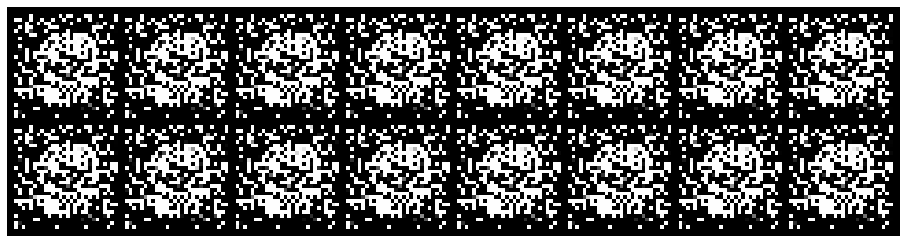

Epoch: [14/200], Batch Num: [300/600]
Discriminator Loss: 0.0000, Generator Loss: 84.7890
D(x): 1.0000, D(G(z)): 0.0000


Epoch: [14/200], Batch Num: [400/600]
Discriminator Loss: 0.0000, Generator Loss: 86.0871
D(x): 1.0000, D(G(z)): 0.0000


Epoch: [14/200], Batch Num: [500/600]
Discriminator Loss: 0.0000, Generator Loss: 84.3452
D(x): 1.0000, D(G(z)): 0.0000
Training:   8%|▊         | 15/200 [11:34<2:02:30, 39.73s/it]

Epoch: [15/200], Batch Num: [0/600]
Discriminator Loss: 0.0000, Generator Loss: 84.4066
D(x): 1.0000, D(G(z)): 0.0000


Epoch: [15/200], Batch Num: [100/600]
Discriminator Loss: 0.0000, Generator Loss: 84.0489
D(x): 1.0000, D(G(z)): 0.0000


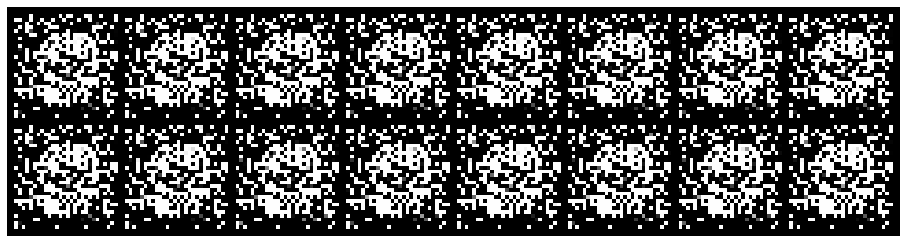

Epoch: [15/200], Batch Num: [200/600]
Discriminator Loss: 0.0000, Generator Loss: 83.9776
D(x): 1.0000, D(G(z)): 0.0000


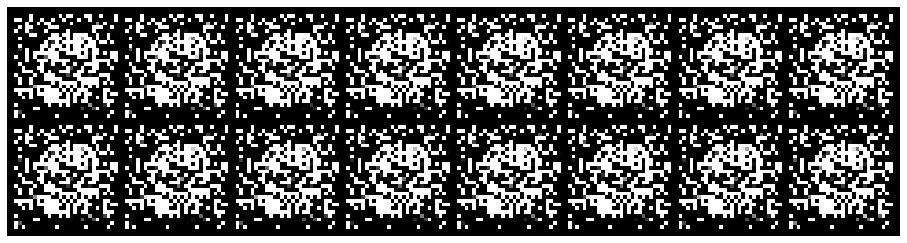

Epoch: [15/200], Batch Num: [300/600]
Discriminator Loss: 0.0000, Generator Loss: 84.1374
D(x): 1.0000, D(G(z)): 0.0000


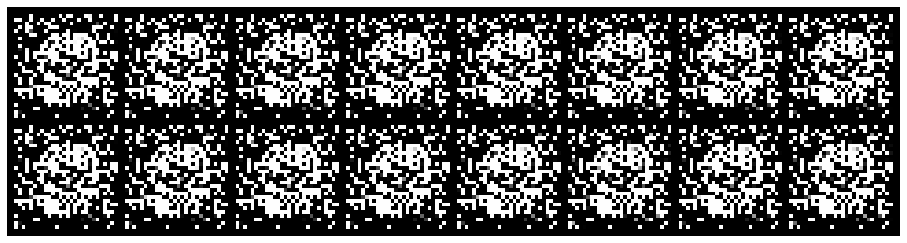

Epoch: [15/200], Batch Num: [400/600]
Discriminator Loss: 0.0000, Generator Loss: 84.4294
D(x): 1.0000, D(G(z)): 0.0000


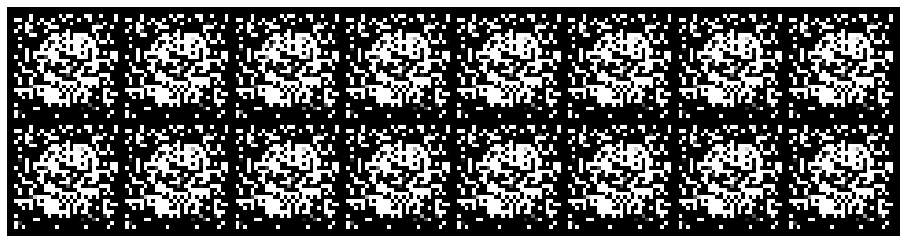

Epoch: [15/200], Batch Num: [500/600]
Discriminator Loss: 0.0000, Generator Loss: 82.5846
D(x): 1.0000, D(G(z)): 0.0000
Training:   8%|▊         | 16/200 [12:08<1:57:03, 38.17s/it]

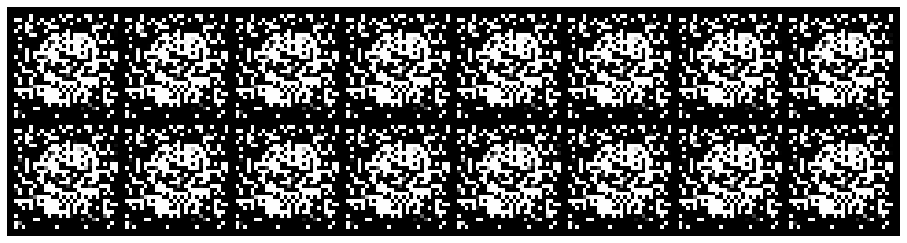

Epoch: [16/200], Batch Num: [0/600]
Discriminator Loss: 0.0000, Generator Loss: 83.3719
D(x): 1.0000, D(G(z)): 0.0000


Epoch: [16/200], Batch Num: [100/600]
Discriminator Loss: 0.0000, Generator Loss: 83.7677
D(x): 1.0000, D(G(z)): 0.0000


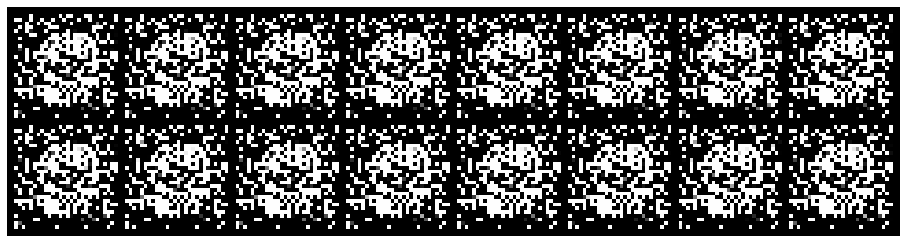

Epoch: [16/200], Batch Num: [200/600]
Discriminator Loss: 0.0000, Generator Loss: 83.5338
D(x): 1.0000, D(G(z)): 0.0000


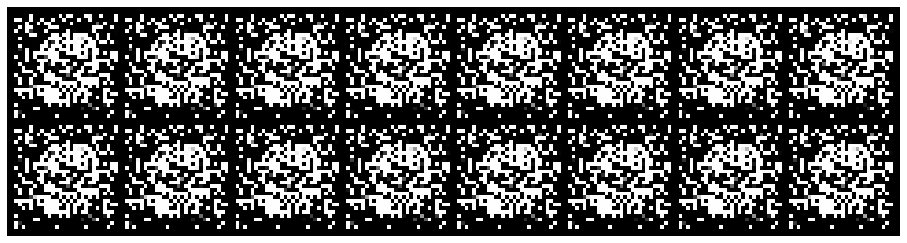

Epoch: [16/200], Batch Num: [300/600]
Discriminator Loss: 0.0000, Generator Loss: 85.5797
D(x): 1.0000, D(G(z)): 0.0000


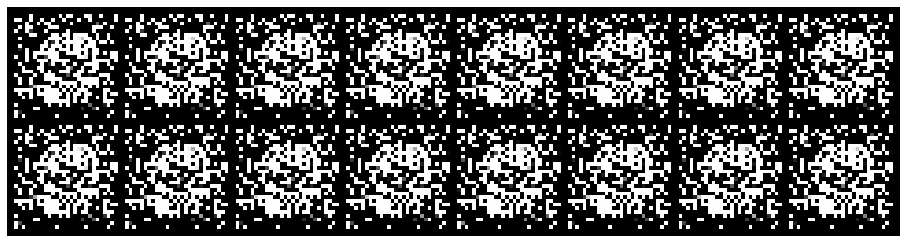

Epoch: [16/200], Batch Num: [400/600]
Discriminator Loss: 0.0000, Generator Loss: 85.6102
D(x): 1.0000, D(G(z)): 0.0000


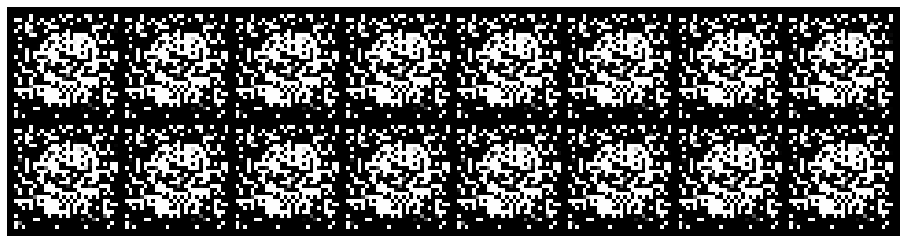

Epoch: [16/200], Batch Num: [500/600]
Discriminator Loss: 0.0000, Generator Loss: 82.8669
D(x): 1.0000, D(G(z)): 0.0000
Training:   8%|▊         | 17/200 [12:42<1:52:41, 36.95s/it]

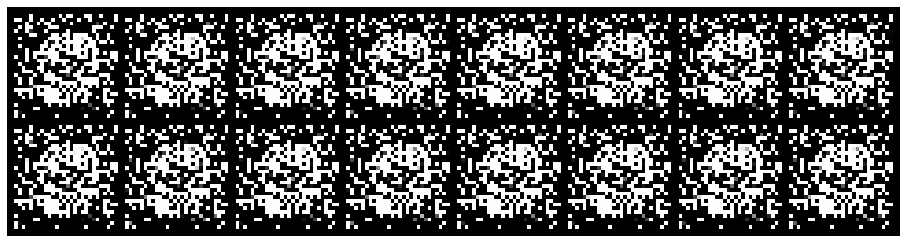

Epoch: [17/200], Batch Num: [0/600]
Discriminator Loss: 0.0000, Generator Loss: 82.9659
D(x): 1.0000, D(G(z)): 0.0000


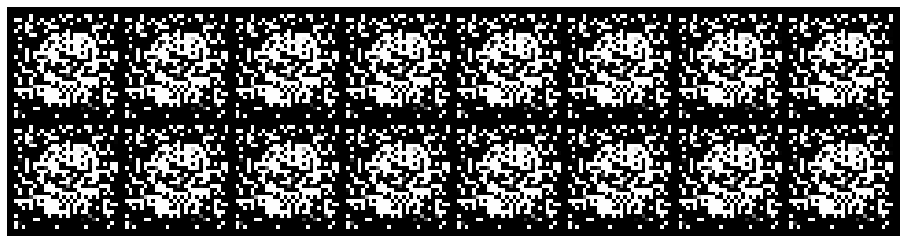

Epoch: [17/200], Batch Num: [100/600]
Discriminator Loss: 0.0000, Generator Loss: 83.7996
D(x): 1.0000, D(G(z)): 0.0000


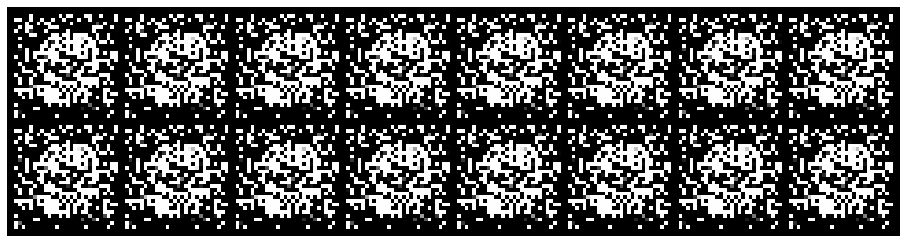

Epoch: [17/200], Batch Num: [200/600]
Discriminator Loss: 0.0000, Generator Loss: 81.5782
D(x): 1.0000, D(G(z)): 0.0000


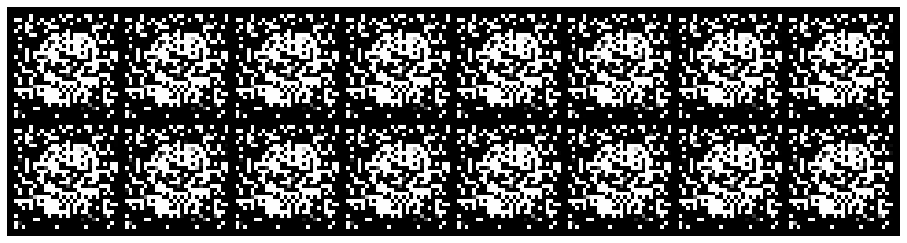

Epoch: [17/200], Batch Num: [300/600]
Discriminator Loss: 0.0000, Generator Loss: 83.0898
D(x): 1.0000, D(G(z)): 0.0000


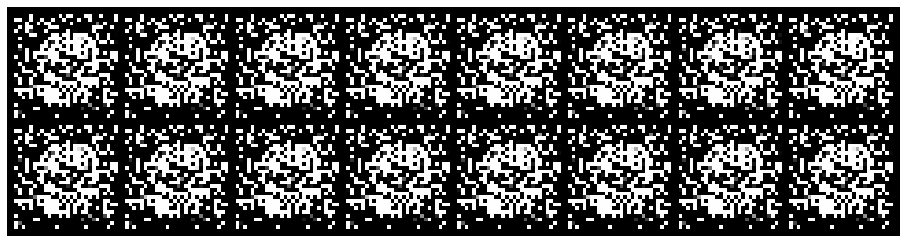

Epoch: [17/200], Batch Num: [400/600]
Discriminator Loss: 0.0000, Generator Loss: 84.6795
D(x): 1.0000, D(G(z)): 0.0000


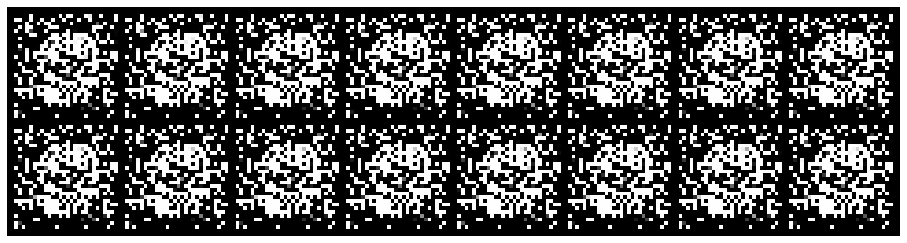

Epoch: [17/200], Batch Num: [500/600]
Discriminator Loss: 0.0000, Generator Loss: 83.2747
D(x): 1.0000, D(G(z)): 0.0000
Training:   9%|▉         | 18/200 [13:17<1:49:52, 36.22s/it]

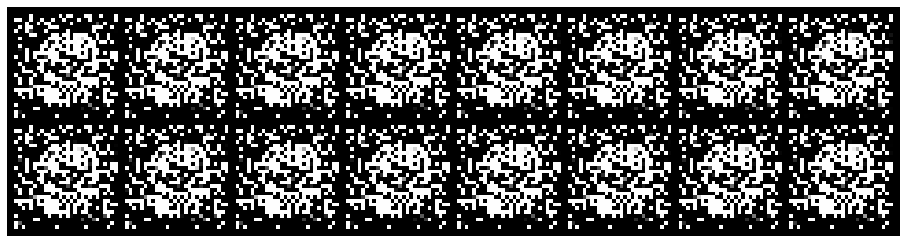

Epoch: [18/200], Batch Num: [0/600]
Discriminator Loss: 0.0000, Generator Loss: 82.1259
D(x): 1.0000, D(G(z)): 0.0000


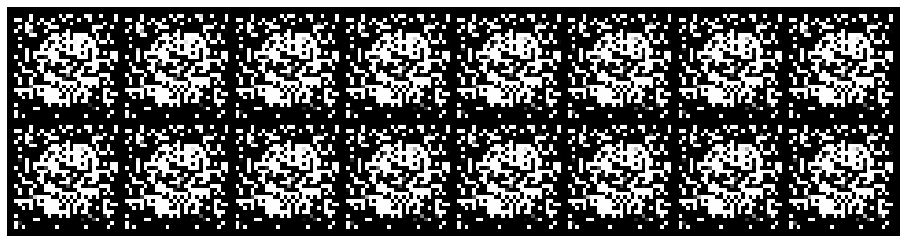

Epoch: [18/200], Batch Num: [100/600]
Discriminator Loss: 0.0000, Generator Loss: 80.9884
D(x): 1.0000, D(G(z)): 0.0000


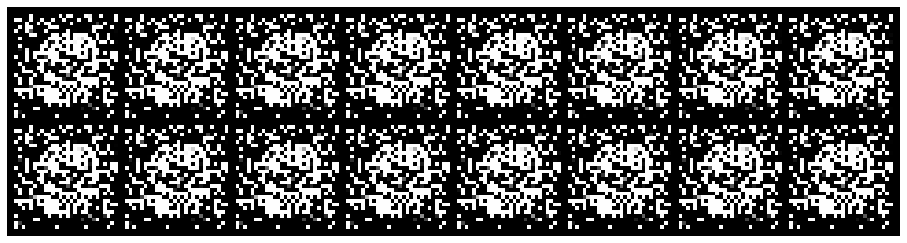

Epoch: [18/200], Batch Num: [200/600]
Discriminator Loss: 0.0000, Generator Loss: 82.8296
D(x): 1.0000, D(G(z)): 0.0000


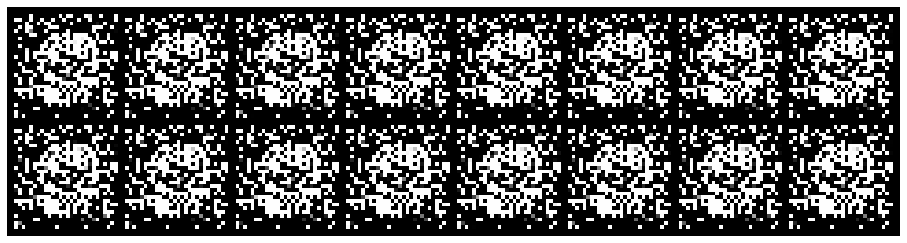

Epoch: [18/200], Batch Num: [300/600]
Discriminator Loss: 0.0000, Generator Loss: 83.4022
D(x): 1.0000, D(G(z)): 0.0000


Epoch: [18/200], Batch Num: [400/600]
Discriminator Loss: 0.0000, Generator Loss: 81.9772
D(x): 1.0000, D(G(z)): 0.0000


Epoch: [18/200], Batch Num: [500/600]
Discriminator Loss: 0.0000, Generator Loss: 82.8739
D(x): 1.0000, D(G(z)): 0.0000
Training:  10%|▉         | 19/200 [13:54<1:49:54, 36.43s/it]

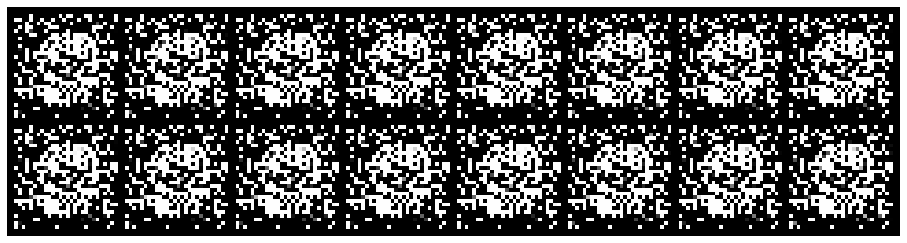

Epoch: [19/200], Batch Num: [0/600]
Discriminator Loss: 0.0000, Generator Loss: 82.9240
D(x): 1.0000, D(G(z)): 0.0000


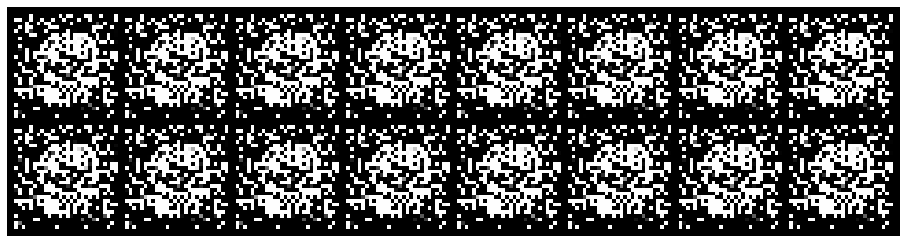

Epoch: [19/200], Batch Num: [100/600]
Discriminator Loss: 0.0000, Generator Loss: 83.4313
D(x): 1.0000, D(G(z)): 0.0000


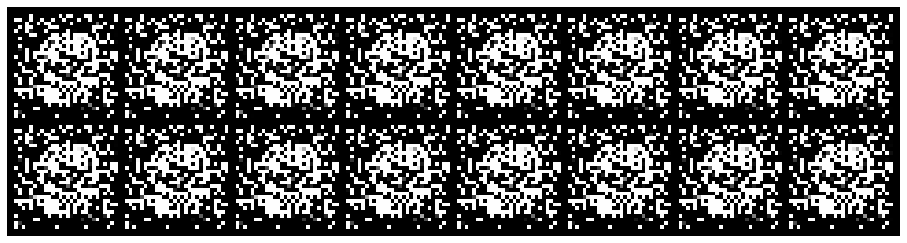

Epoch: [19/200], Batch Num: [200/600]
Discriminator Loss: 0.0000, Generator Loss: 82.9334
D(x): 1.0000, D(G(z)): 0.0000


Epoch: [19/200], Batch Num: [300/600]
Discriminator Loss: 0.0000, Generator Loss: 82.3708
D(x): 1.0000, D(G(z)): 0.0000


Epoch: [19/200], Batch Num: [400/600]
Discriminator Loss: 0.0000, Generator Loss: 84.4666
D(x): 1.0000, D(G(z)): 0.0000


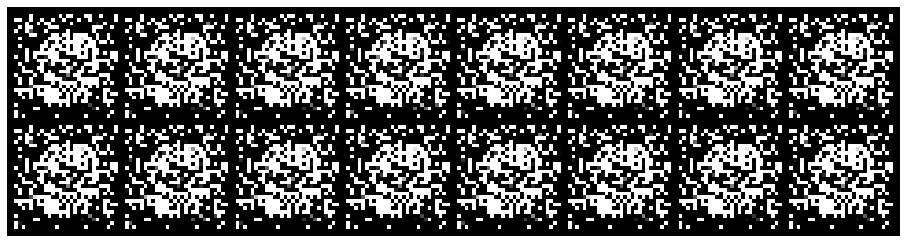

Epoch: [19/200], Batch Num: [500/600]
Discriminator Loss: 0.0000, Generator Loss: 84.3264
D(x): 1.0000, D(G(z)): 0.0000
Training:  10%|█         | 20/200 [14:34<1:52:50, 37.61s/it]

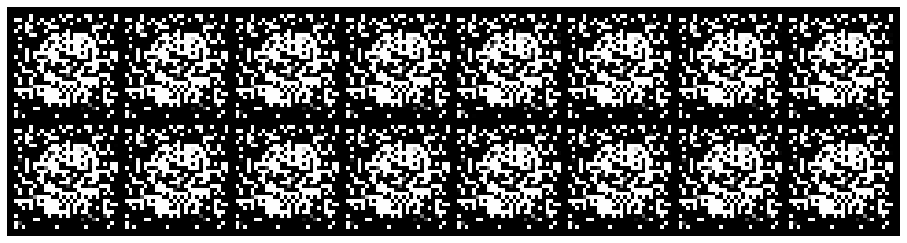

Epoch: [20/200], Batch Num: [0/600]
Discriminator Loss: 0.0000, Generator Loss: 81.8087
D(x): 1.0000, D(G(z)): 0.0000


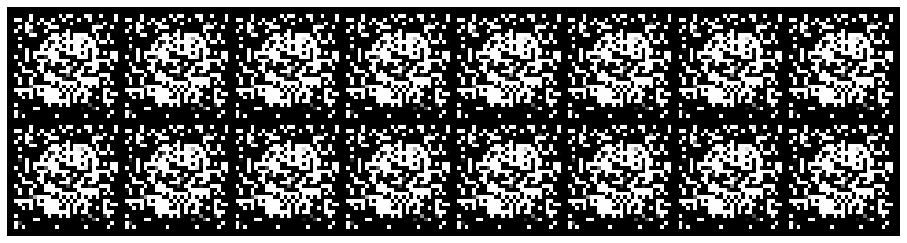

Epoch: [20/200], Batch Num: [100/600]
Discriminator Loss: 0.0000, Generator Loss: 82.1832
D(x): 1.0000, D(G(z)): 0.0000


Epoch: [20/200], Batch Num: [200/600]
Discriminator Loss: 0.0000, Generator Loss: 81.2558
D(x): 1.0000, D(G(z)): 0.0000


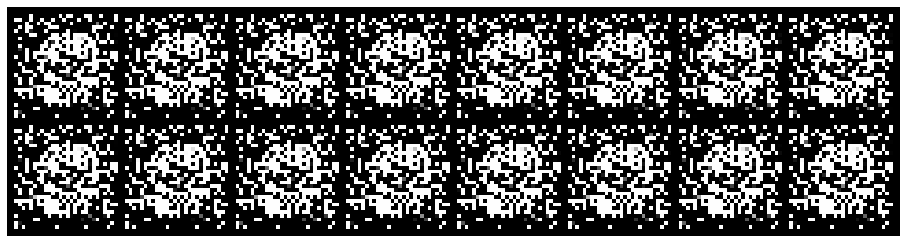

Epoch: [20/200], Batch Num: [300/600]
Discriminator Loss: 0.0000, Generator Loss: 82.1375
D(x): 1.0000, D(G(z)): 0.0000


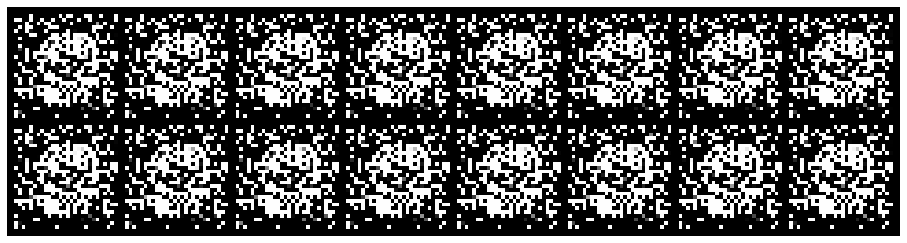

Epoch: [20/200], Batch Num: [400/600]
Discriminator Loss: 0.0000, Generator Loss: 81.4988
D(x): 1.0000, D(G(z)): 0.0000


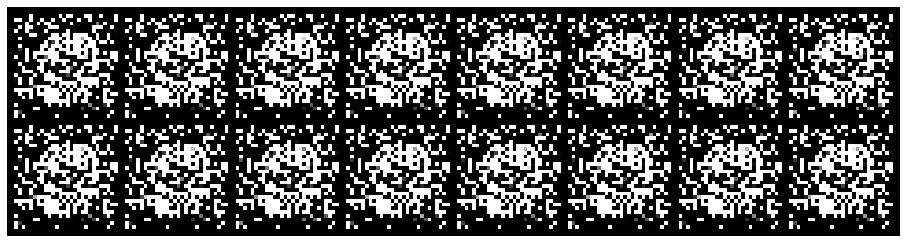

Epoch: [20/200], Batch Num: [500/600]
Discriminator Loss: 0.0000, Generator Loss: 82.4300
D(x): 1.0000, D(G(z)): 0.0000
Training:  10%|█         | 21/200 [15:13<1:53:28, 38.04s/it]

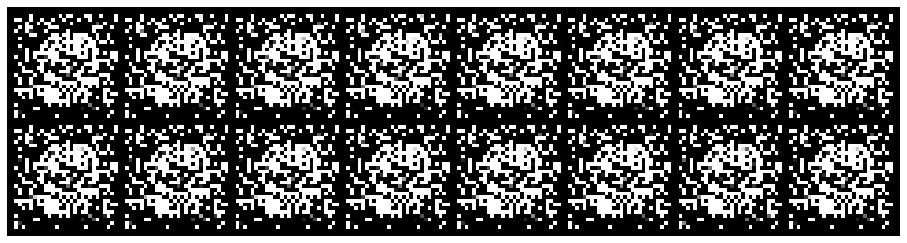

Epoch: [21/200], Batch Num: [0/600]
Discriminator Loss: 0.0000, Generator Loss: 83.2584
D(x): 1.0000, D(G(z)): 0.0000


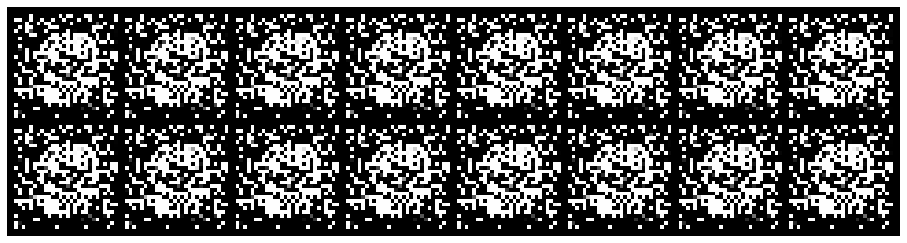

Epoch: [21/200], Batch Num: [100/600]
Discriminator Loss: 0.0000, Generator Loss: 82.3842
D(x): 1.0000, D(G(z)): 0.0000


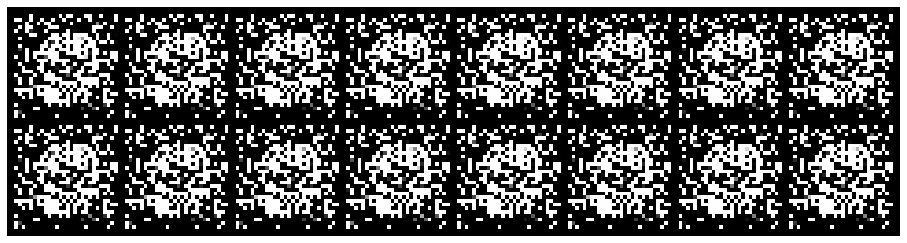

Epoch: [21/200], Batch Num: [200/600]
Discriminator Loss: 0.0000, Generator Loss: 81.9470
D(x): 1.0000, D(G(z)): 0.0000


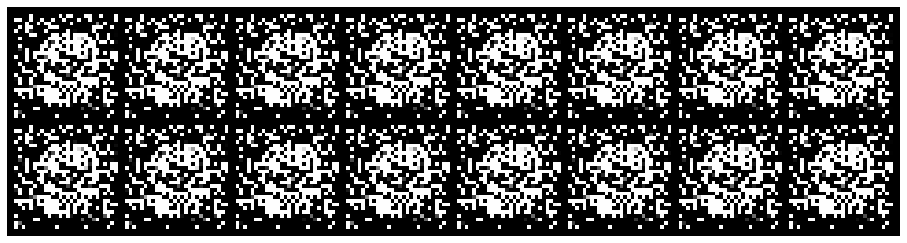

Epoch: [21/200], Batch Num: [300/600]
Discriminator Loss: 0.0000, Generator Loss: 81.9098
D(x): 1.0000, D(G(z)): 0.0000


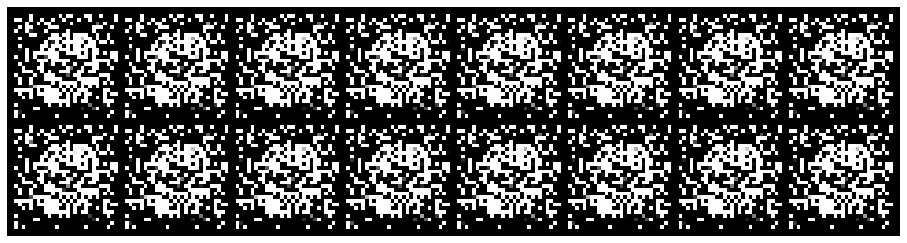

Epoch: [21/200], Batch Num: [400/600]
Discriminator Loss: 0.0000, Generator Loss: 82.1747
D(x): 1.0000, D(G(z)): 0.0000


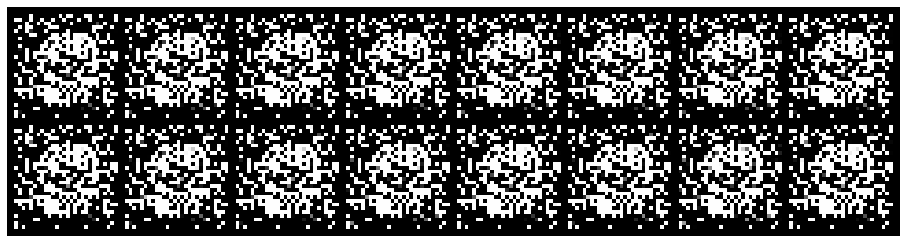

Epoch: [21/200], Batch Num: [500/600]
Discriminator Loss: 0.0000, Generator Loss: 81.5139
D(x): 1.0000, D(G(z)): 0.0000
Training:  11%|█         | 22/200 [15:52<1:53:23, 38.22s/it]

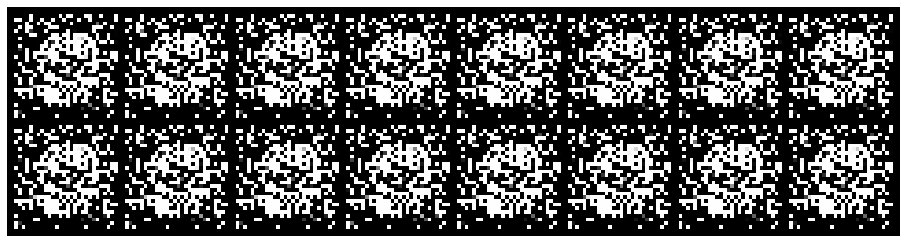

Epoch: [22/200], Batch Num: [0/600]
Discriminator Loss: 0.0000, Generator Loss: 82.9203
D(x): 1.0000, D(G(z)): 0.0000


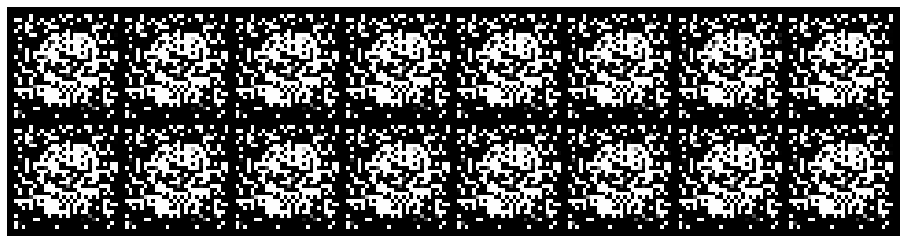

Epoch: [22/200], Batch Num: [100/600]
Discriminator Loss: 0.0000, Generator Loss: 82.1466
D(x): 1.0000, D(G(z)): 0.0000


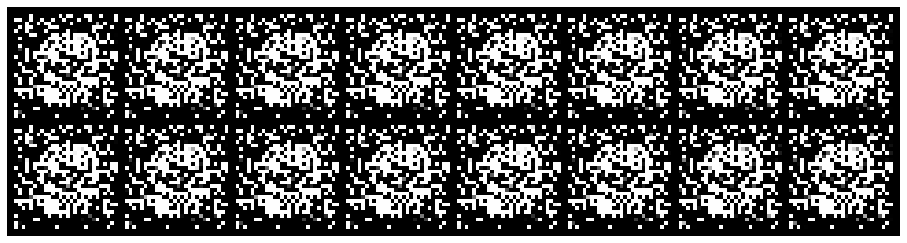

Epoch: [22/200], Batch Num: [200/600]
Discriminator Loss: 0.0000, Generator Loss: 83.4523
D(x): 1.0000, D(G(z)): 0.0000


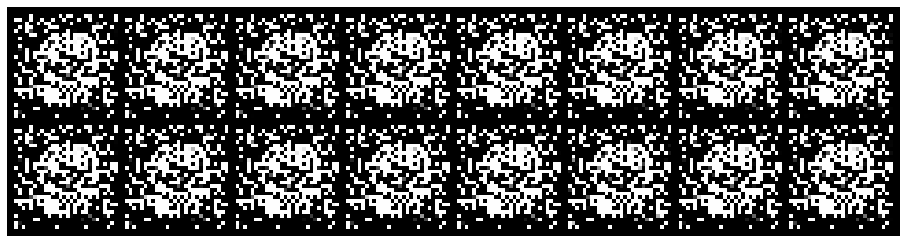

Epoch: [22/200], Batch Num: [300/600]
Discriminator Loss: 0.0000, Generator Loss: 82.0547
D(x): 1.0000, D(G(z)): 0.0000


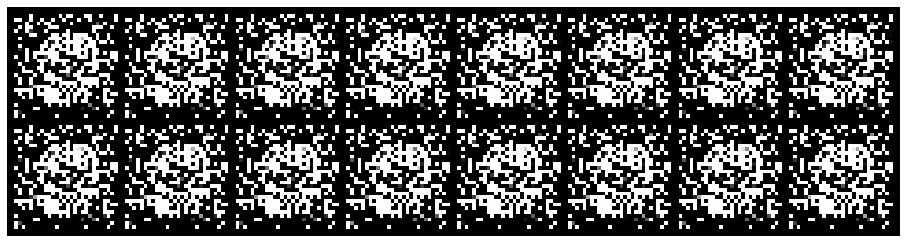

Epoch: [22/200], Batch Num: [400/600]
Discriminator Loss: 0.0000, Generator Loss: 82.2687
D(x): 1.0000, D(G(z)): 0.0000


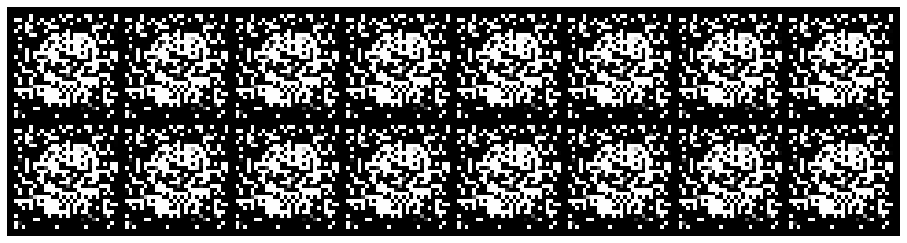

Epoch: [22/200], Batch Num: [500/600]
Discriminator Loss: 0.0000, Generator Loss: 81.4760
D(x): 1.0000, D(G(z)): 0.0000
Training:  12%|█▏        | 23/200 [16:31<1:53:51, 38.59s/it]

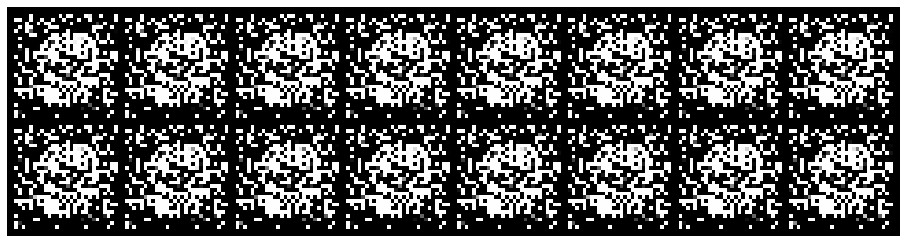

Epoch: [23/200], Batch Num: [0/600]
Discriminator Loss: 0.0000, Generator Loss: 82.1099
D(x): 1.0000, D(G(z)): 0.0000


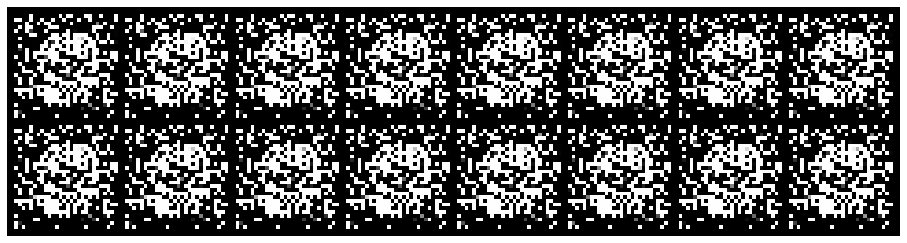

Epoch: [23/200], Batch Num: [100/600]
Discriminator Loss: 0.0000, Generator Loss: 81.0393
D(x): 1.0000, D(G(z)): 0.0000


In [5]:
Experiment().run(200)